<h1><center>Segmenting and Clustering Neighborhoods in Istanbul</center></h1>

## 1. Introduction

&emsp; Istanbul is the largest city in Turkey and the country's economic, cultural and historic center. As a resident of this city, I decided to create my project about Istanbul. The city straddles the Bosphorus strait, and lies in both Europe and Asia, with a population of over 15 million residents, comprising 19% of the population of Turkey. Istanbul is also the most populous city in Europe and the world's fifteenth-largest city.


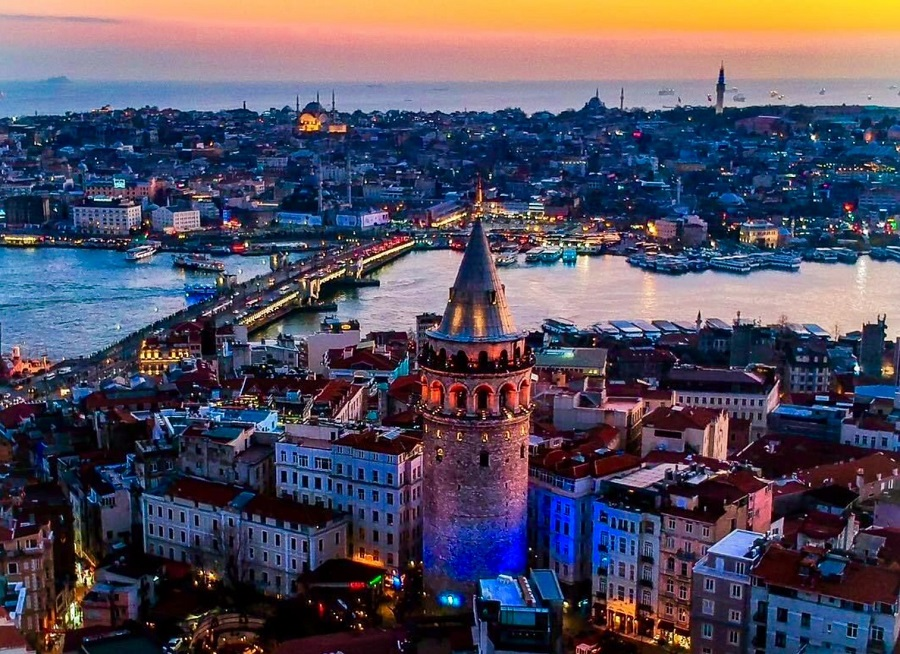

&emsp; As we mentioned in the first paragraph, millions of people live in Istanbul and moreover, many people are planning to live in Istanbul. Thus, the goal I want to reach with this project is to give a simple recommendation to people: Which neighborhood of Istanbul is suits you best? The target audience is both people planning to move to Istanbul and people who are not happy where they live in Istanbul.

### 1.1 Data sources

To solve this problem, we need the following variables:
<br> <li>  Neighborhood,
<br> <li> Boroughs,
<br> <li> Population,
<br> <li> Area(in $km^{2}$),
<br> <li> Density: Population density per $km^{2}$,
<br> <li> Latitude,
<br> <li> Longitude.
<br>
<br>
&emsp; Firstly, for the Istanbul neighborhood data, I will scrape the page "https://www.atlasbig.com/tr/istanbul-mahalleleri-nufus-yogunlugu" that includes the neighborhood names, population, area and population density. Then, I will wrangle the data and clean it. I will use the *geopy* library to obtain the coordinate information of the neighborhoods. Finally, I will use *Foursquare API* to obtain the most common venues in given neighborhood of Istanbul.

## 2. Methodology

### 2.1 Load and explore dataset

Firstly, we will import all the libraries we need.

In [1]:
import numpy as np
import pandas as pd
import json
from bs4 import BeautifulSoup
import requests
from geopy.geocoders import Nominatim
import folium
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

print('Libraries imported.')

Libraries imported.


Let's scrape the data with *requests* and quick look at the data.

In [2]:
r = requests.get('https://www.atlasbig.com/tr/istanbul-mahalleleri-nufus-yogunlugu').text
parsed = BeautifulSoup(r, 'lxml')
tables = parsed.find('table')
tables

<table class="table table-bordered" id="data-table">
<caption>Istanbul'un Mahallelerinin Nüfus Yogunlugu</caption>
<thead>
<tr>
<th>Sıra</th>
<th>Mahalle</th>
<th>Ilce</th>
<th>Nüfus Yogunlugu(kisi/km2)</th>
<th>Nüfus</th>
<th>Yüzölcümü(km2)</th>
</tr>
</thead>
<tbody>
<tr class="data-row">
<td>1</td>
<td>
<a href="#" onclick="zoomMap('630');return false;">
                                Yeşiltepe
                            </a>
</td>
<td>Zeytinburnu</td>
<td>				
								
																											96,576 
																									
                            </td>
<td>				
								
																											21,679 
																									
                            </td>
<td>				
								
																											0.22 
																									
                            </td>
</tr>
<tr class="data-row">
<td>2</td>
<td>
<a href="#" onclick="zoomMap('112');return false;">
                                Fatih
                            </a>
</td>
<td>Esenler</td>
<td>				
		

The *pandas* **read_html()** function gives us a list of all the tables on the page. So, let's define a new variable that includes these tables.

In [3]:
data_list = pd.read_html(str(tables))
data_list

[     Sıra               Mahalle           Ilce  Nüfus Yogunlugu(kisi/km2)  \
 0       1             Yeşiltepe    Zeytinburnu                    96576.0   
 1       2                 Fatih        Esenler                    89562.0   
 2       3  Mareşal Fevzi Çakmak       Güngören                    86603.0   
 3       4             Nenehatun        Esenler                    86504.0   
 4       5               Yenigün       Bağcılar                    84843.0   
 5       6       Kâzım Karabekir        Esenler                    84393.0   
 6       7              Hürriyet   Bahçelievler                    82759.0   
 7       8             Akıncılar       Güngören                    82208.0   
 8       9           Siyavuşpaşa   Bahçelievler                    81140.0   
 9      10             Davutpaşa        Esenler                    79991.0   
 10     11            Turgutreis        Esenler                    79872.0   
 11     12              Nuripaşa    Zeytinburnu                 

Our variable **data_list** has 1 table and we need to get it as dataframe. Let's define our dataframe as **df_istanbul**.

In [4]:
df_istanbul = pd.DataFrame(data_list[0])
df_istanbul

Sıra               Mahalle           Ilce  Nüfus Yogunlugu(kisi/km2)  \
0       1             Yeşiltepe    Zeytinburnu                    96576.0   
1       2                 Fatih        Esenler                    89562.0   
2       3  Mareşal Fevzi Çakmak       Güngören                    86603.0   
3       4             Nenehatun        Esenler                    86504.0   
4       5               Yenigün       Bağcılar                    84843.0   
5       6       Kâzım Karabekir        Esenler                    84393.0   
6       7              Hürriyet   Bahçelievler                    82759.0   
7       8             Akıncılar       Güngören                    82208.0   
8       9           Siyavuşpaşa   Bahçelievler                    81140.0   
9      10             Davutpaşa        Esenler                    79991.0   
10     11            Turgutreis        Esenler                    79872.0   
11     12              Nuripaşa    Zeytinburnu                    79421.0   
12     13                 Zafer   Bahçelievler                    78772.0   
13     14               Çırpıcı    Zeytinburnu                    75658.0   
14     15            Mimarsinan        Esenler                    75555.0   
15     16            Harmantepe      Kağıthane                    75102.0   
16     17              Menderes        Esenler                    74680.0   
17     18               Soğanlı   Bahçelievler                    74494.0   
18     19               Gültepe      Kağıthane                    72930.0   
19     20    Kadı Mehmet Efendi        Beyoğlu                    72513.0   
20     21             Yenidoğan    Zeytinburnu                    69744.0   
21     22                Gökalp    Zeytinburnu                    69558.0   
22     23             Güneştepe       Güngören                    69528.0   
23     24           Namık Kemal        Esenler                    69474.0   
24     25            Veliefendi    Zeytinburnu                    69001.0   
25     26          Fevzi Çakmak        Esenler                    68758.0   
26     27             Şemsipaşa  Gaziosmanpaşa                    68734.0   
27     28                 Fatih       Bağcılar                    68402.0   
28     29               Atikali          Fatih                    66843.0   
29     30             İncirtepe       Esenyurt                    66533.0   
..    ...                   ...            ...                        ...   
924   925               Hacıllı           Şile                       15.9   
925   926              Oruçoğlu           Şile                       15.1   
926   927              Ulupelit           Şile                       14.3   
927   928             Karakiraz           Şile                       13.9   
928   929                  Teke           Şile                       13.9   
929   930               Balaban     Arnavutköy                       13.8   
930   931             Yassıören     Arnavutköy                       13.7   
931   932                 Göksu           Şile                       13.4   
932   933              Çengilli           Şile                       13.2   
933   934              Ağaçdere           Şile                       13.2   
934   935               Belgrat        Çatalca                       13.1   
935   936               Bekirli        Silivri                       12.9   
936   937            Polonezköy         Beykoz                       12.8   
937   938              Kurfallı        Silivri                       12.4   
938   939              Celepköy        Çatalca                       12.2   
939   940              Yaylacık        Çatalca                       11.7   
940   941               Çataklı           Şile                       11.7   
941   942                 Kalem           Şile                       11.2   
942   943                 Kurna           Şile                       11.0   
943   944               Erenler           Şile                       11.0   
9

Rename the columns and examine the resulting dataframe.

In [5]:
df_istanbul.drop(['Sıra'], axis =1, inplace=True)
df_istanbul.columns = ['Neighborhood', 'Boroughs', 'Density', 'Population', 'Area']
df_istanbul.head()

Neighborhood     Boroughs  Density  Population  Area
0             Yeşiltepe  Zeytinburnu  96576.0     21679.0  0.22
1                 Fatih      Esenler  89562.0     45797.0  0.51
2  Mareşal Fevzi Çakmak     Güngören  86603.0     31630.0  0.37
3             Nenehatun      Esenler  86504.0     43328.0  0.50
4               Yenigün     Bağcılar  84843.0     23112.0  0.27

In [6]:
df_istanbul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 5 columns):
Neighborhood    954 non-null object
Boroughs        954 non-null object
Density         954 non-null float64
Population      954 non-null float64
Area            954 non-null float64
dtypes: float64(3), object(2)
memory usage: 37.3+ KB


Let's add the borough name next to the name of the neighborhood, in the same column. Because there are some popular neighborhood names in Istanbul that are used more than once.

In [7]:
df_istanbul['Neighborhood'] = df_istanbul['Neighborhood'] + ', ' + df_istanbul['Boroughs']
df_istanbul.head()

Neighborhood     Boroughs  Density  Population  Area
0          Yeşiltepe, Zeytinburnu  Zeytinburnu  96576.0     21679.0  0.22
1                  Fatih, Esenler      Esenler  89562.0     45797.0  0.51
2  Mareşal Fevzi Çakmak, Güngören     Güngören  86603.0     31630.0  0.37
3              Nenehatun, Esenler      Esenler  86504.0     43328.0  0.50
4               Yenigün, Bağcılar     Bağcılar  84843.0     23112.0  0.27

Now we can check if duplicate values exist in our dataframe.

In [8]:
len(df_istanbul['Neighborhood'].unique()) == df_istanbul.shape[0] 

True

Use *geopy* library to get the latitude and longitude values of Istanbul.

In [9]:
address = 'Istanbul, TR'

geolocator = Nominatim(user_agent="Istanbul_Maps")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Istanbul are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Istanbul are 41.0096334, 28.9651646.


Now, we will obtain the coordinate information of the neighborhoods.

In [10]:
geolocator = Nominatim(user_agent = 'Istanbul_Maps')

lat=[]
lng=[]

for i in range(len(df_istanbul)):
    
    location = geolocator.geocode("{}".format(df_istanbul.loc[i,'Neighborhood']))
    try:
        lat.insert(i,location.latitude)
        lng.insert(i,location.longitude)
        
    except: 
        lat.insert(i,61) # If the neighborhood has no coordinate informations, fill them with 61.
        lng.insert(i,61) # Same for longitude.
        print("Coordinate information for {} doesn't exist!".format(df_istanbul.loc[i,'Neighborhood']))
        
    
    
# Add new columns with extracted values
df_istanbul['Latitude'] = lat
df_istanbul['Longitude'] = lng

# Examine the data
df_istanbul.head()

Coordinate information for Mareşal Fevzi Çakmak, Güngören doesn't exist!
Coordinate information for Turgutreis, Esenler doesn't exist!
Coordinate information for Mimarsinan, Esenler doesn't exist!
Coordinate information for Kalyoncukulluğu, Beyoğlu doesn't exist!
Coordinate information for Hırkaişerif, Fatih doesn't exist!
Coordinate information for Küçükpiyale, Beyoğlu doesn't exist!
Coordinate information for Mollagürani, Fatih doesn't exist!
Coordinate information for Keçecipiri, Beyoğlu doesn't exist!
Coordinate information for Piripaşa, Beyoğlu doesn't exist!
Coordinate information for Aşıkveysel, Ataşehir doesn't exist!
Coordinate information for Çatmamescit, Beyoğlu doesn't exist!
Coordinate information for Yukarımahalle, Kartal doesn't exist!
Coordinate information for Yeniçamlıca, Ataşehir doesn't exist!
Coordinate information for Ortamahalle, Kartal doesn't exist!
Coordinate information for Güzelyurt (Haramidere), Esenyurt doesn't exist!
Coordinate information for Bahçeköy Ye

Neighborhood     Boroughs  Density  Population  Area  \
0          Yeşiltepe, Zeytinburnu  Zeytinburnu  96576.0     21679.0  0.22   
1                  Fatih, Esenler      Esenler  89562.0     45797.0  0.51   
2  Mareşal Fevzi Çakmak, Güngören     Güngören  86603.0     31630.0  0.37   
3              Nenehatun, Esenler      Esenler  86504.0     43328.0  0.50   
4               Yenigün, Bağcılar     Bağcılar  84843.0     23112.0  0.27   

    Latitude  Longitude  
0  40.992219  28.900607  
1  41.041988  28.865682  
2  61.000000  61.000000  
3  41.035747  28.878859  
4  41.022218  28.859602

Let's collect the data of the boroughs in a dataframe **istanbul_boroughs**. We will use this dataframe for visualization.

In [11]:
istanbul_boroughs = df_istanbul.groupby('Boroughs')['Density','Population'].sum().reset_index()
istanbul_boroughs.head()

Boroughs   Density  Population
0    Arnavutköy  121012.2    261655.0
1      Ataşehir  345980.0    423372.0
2       Avcılar  216556.0    435682.0
3  Bahçelievler  569954.0    598454.0
4      Bakırköy  212747.0    222370.0

And let's delete the neighborhoods whose latitude value is equal to 61.

In [12]:
df_istanbul = df_istanbul[df_istanbul.Latitude != 61]
df_istanbul.head()

Neighborhood     Boroughs  Density  Population  Area  \
0    Yeşiltepe, Zeytinburnu  Zeytinburnu  96576.0     21679.0  0.22   
1            Fatih, Esenler      Esenler  89562.0     45797.0  0.51   
3        Nenehatun, Esenler      Esenler  86504.0     43328.0  0.50   
4         Yenigün, Bağcılar     Bağcılar  84843.0     23112.0  0.27   
5  Kâzım Karabekir, Esenler      Esenler  84393.0     35790.0  0.42   

    Latitude  Longitude  
0  40.992219  28.900607  
1  41.041988  28.865682  
3  41.035747  28.878859  
4  41.022218  28.859602  
5  41.045372  28.873215

In [13]:
df_istanbul.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 912 entries, 0 to 953
Data columns (total 7 columns):
Neighborhood    912 non-null object
Boroughs        912 non-null object
Density         912 non-null float64
Population      912 non-null float64
Area            912 non-null float64
Latitude        912 non-null float64
Longitude       912 non-null float64
dtypes: float64(5), object(2)
memory usage: 57.0+ KB


Let's create a map of Istanbul with neighborhoods superimposed on top.

In [14]:
# create map of Istanbul using latitude and longitude values
map_istanbul = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df_istanbul['Latitude'], df_istanbul['Longitude'], df_istanbul['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_istanbul)  
    
map_istanbul

### 2.2 Explore neighborhoods in Istanbul

We will obtain the most common venues in given neighborhood of Istanbul with *Foursquare API* but first, let's define Foursquare credentials and version.

In [18]:
CLIENT_ID = 'FQB1ZSOBUGZKQEFO0QTAMBDB225K22CQT4VT1ZHA2XL5Z4KY' # Foursquare ID
CLIENT_SECRET = 'JTDZNE3WL3R4CCX0ZIM23YSHC1M53HS33SZACFX0LYH1EDS1' # Foursquare Secret
VERSION = '20190505' # Foursquare API version

Let's create a function to explore.

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # Make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list]) # Collect the obtained information in a dataframe
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'] # Rename the columns
    
    return(nearby_venues)

Let's get the top 100 venues(**LIMIT**) that are in each neighborhood within a **RADIUS** of 1 kilometers and define it as **istanbul_venues**.

In [20]:
istanbul_venues = getNearbyVenues(names = df_istanbul['Neighborhood'], 
                                  latitudes = df_istanbul['Latitude'], 
                                  longitudes = df_istanbul['Longitude'], 
                                  radius = 1000, 
                                  )


Examine the dataframe.

In [21]:
istanbul_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Yeşiltepe, Zeytinburnu              40.992219               28.900607   
1  Yeşiltepe, Zeytinburnu              40.992219               28.900607   
2  Yeşiltepe, Zeytinburnu              40.992219               28.900607   
3  Yeşiltepe, Zeytinburnu              40.992219               28.900607   
4  Yeşiltepe, Zeytinburnu              40.992219               28.900607   

                                   Venue  Venue Latitude  Venue Longitude  \
0                   Büyükada Pastahanesi       40.990421        28.899727   
1                         Paşam Dondurma       40.991374        28.903770   
2                                  Sütdo       40.992485        28.903841   
3  Power Club Vücut Geliştirme & Fitness       40.991330        28.903864   
4                             İTALY CİTY       40.994396        28.901729   

         Venue Category  
0          Cupcake Shop  
1        Ice Cream Shop  
2        Ice Cream Shop  
3  Gym / Fitness Center  
4           Men's Store

Let's check the size of the resulting dataframe.

In [22]:
istanbul_venues.shape

(63552, 7)

Let's find out how many unique categories can be created from all the returned venues.

In [23]:
print("{} venues were found in Istanbul".format(len(istanbul_venues)))
print("------------")
print("{} venues categories were found in Istanbul".format(len(istanbul_venues['Venue Category'].unique())))

63552 venues were found in Istanbul
------------
542 venues categories were found in Istanbul


### 2.3 Analyze each neighborhood

To find clusters of venue categories in the different neighborhoods, we will transform the data frame with the venue categories, associated to neighborhoods, by one-hot encoding (0/1), as seen in the figure below.

In [24]:
# One hot encoding
istanbul_onehot = pd.get_dummies(istanbul_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
istanbul_onehot['Neighborhood'] = istanbul_venues['Neighborhood'] 

# Move neighborhood column to the first column
neighborhood_index = istanbul_onehot.columns.get_loc('Neighborhood') 
onehot_columns = [istanbul_onehot.columns[neighborhood_index]] + list(istanbul_onehot.columns[:neighborhood_index]) + list(istanbul_onehot.columns[neighborhood_index+1:])

istanbul_onehot = istanbul_onehot[onehot_columns]
istanbul_onehot.head()

Neighborhood  ATM  Accessories Store  Adult Boutique  \
0  Yeşiltepe, Zeytinburnu    0                  0               0   
1  Yeşiltepe, Zeytinburnu    0                  0               0   
2  Yeşiltepe, Zeytinburnu    0                  0               0   
3  Yeşiltepe, Zeytinburnu    0                  0               0   
4  Yeşiltepe, Zeytinburnu    0                  0               0   

   Adult Education Center  Advertising Agency  Afghan Restaurant  \
0                       0                   0                  0   
1                       0                   0                  0   
2                       0                   0                  0   
3                       0                   0                  0   
4                       0                   0                  0   

   African Restaurant  Airport  Airport Gate  ...  Wine Bar  Wine Shop  \
0                   0        0             0  ...         0          0   
1                   0        0             0  ...         0          0   
2                   0        0             0  ...         0          0   
3                   0        0             0  ...         0          0   
4                   0        0             0  ...         0          0   

   Winery  Wings Joint  Women's Store  Yemeni Restaurant  Yoga Studio  Zoo  \
0       0            0              0                  0            0    0   
1       0            0              0                  0            0    0   
2       0            0              0                  0            0    0   
3       0            0              0                  0            0    0   
4       0            0              0                  0            0    0   

   Zoo Exhibit  Çöp Şiş Place  
0            0              0  
1            0              0  
2            0              0  
3            0              0  
4            0              0  

[5 rows x 542 columns]

Let's check the size of the resulting dataframe

In [25]:
istanbul_onehot.shape

(63552, 542)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [26]:
istanbul_grouped = istanbul_onehot.groupby('Neighborhood').mean().reset_index()
istanbul_grouped

Neighborhood       ATM  Accessories Store  \
0                19 Mayıs, Büyükçekmece  0.000000               0.00   
1                     19 Mayıs, Kadıköy  0.000000               0.00   
2                       19 Mayıs, Şişli  0.000000               0.00   
3                   50. Yıl, Sultangazi  0.000000               0.00   
4                   75. Yıl, Sultangazi  0.000000               0.00   
5                    Abbasağa, Beşiktaş  0.000000               0.00   
6    Abdurrahman Nafiz Gürman, Güngören  0.000000               0.00   
7           Abdurrahmangazi, Sancaktepe  0.000000               0.00   
8          Abdurrahmangazi, Sultanbeyli  0.000000               0.00   
9                       Acarlar, Beykoz  0.000000               0.00   
10                    Acıbadem, Kadıköy  0.000000               0.00   
11                    Acıbadem, Üsküdar  0.000000               0.00   
12                 Adem Yavuz, Ümraniye  0.000000               0.00   
13                    Adil, Sultanbeyli  0.000000               0.00   
14            Adnan Kahveci, Beylikdüzü  0.000000               0.00   
15               Ahmediye, Büyükçekmece  0.000000               0.00   
16                    Ahmediye, Üsküdar  0.000000               0.00   
17                 Ahmet Yesevi, Pendik  0.000000               0.00   
18            Ahmet Yesevi, Sultanbeyli  0.000000               0.00   
19                        Ahmetli, Şile  0.000000               0.00   
20                      Akalan, Çatalca  0.000000               0.00   
21                    Akatlar, Beşiktaş  0.000000               0.00   
22                       Akbaba, Beykoz  0.000000               0.00   
23                    Akevler, Esenyurt  0.000000               0.00   
24                       Akfırat, Tuzla  0.000000               0.00   
25                        Akpınar, Eyüp  0.000000               0.00   
26                  Akpınar, Sancaktepe  0.000000               0.00   
27                       Aksaray, Fatih  0.000000               0.00   
28                 Akçaburgaz, Esenyurt  0.000000               0.00   
29                       Akçakese, Şile  0.000000               0.00   
..                                  ...       ...                ...   
880                     İshaklı, Beykoz  0.000000               0.00   
881                 İskenderpaşa, Fatih  0.000000               0.00   
882                      İslambey, Eyüp  0.000000               0.00   
883               İsmetpaşa, Bayrampaşa  0.000000               0.00   
884                  İsmetpaşa, Silivri  0.000000               0.00   
885               İsmetpaşa, Sultangazi  0.000000               0.00   
886              İstasyon, Küçükçekmece  0.022222               0.00   
887                     İstasyon, Tuzla  0.027778               0.00   
888                   İstiklal, Beyoğlu  0.000000               0.00   
889                  İstiklal, Esenyurt  0.000000               0.00   
890                  İstiklal, Ümraniye  0.000000               0.01   
891                    İstinye, Sarıyer  0.000000               0.00   
892                    İzzetpaşa, Şişli  0.000000               0.00   
893                 İçerenköy, Ataşehir  0.000000               0.00   
894                      İçmeler, Tuzla  0.000000               0.00   
895               Şahintepe, Başakşehir  0.000000               0.00   
896                    Şahkulu, Beyoğlu  0.000000               0.00   
897                  Şamlar, Başakşehir  0.000000               0.00   
898               Şehit Muhtar, Beyoğlu  0.000000               0.00   
899                  Şehitler, Esenyurt  0.012195               0.00   
900                    Şehremini, Fatih  0.000000               0.00   
901                  Şehsuvarbey, Fatih  0.000000               0.00   
902            Şemsipaşa, Gaziosmanpaşa  0.000000               0.00   
903                 Şenlikköy, Bakırköy  0.000000               0.0

In [27]:
istanbul_grouped.shape

(910, 542)

Let's write a function to sort the venues in descending order.

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = istanbul_grouped['Neighborhood']

for ind in np.arange(istanbul_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(istanbul_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0  19 Mayıs, Büyükçekmece                  Farm            Steakhouse   
1       19 Mayıs, Kadıköy           Coffee Shop                  Café   
2         19 Mayıs, Şişli                  Café           Coffee Shop   
3     50. Yıl, Sultangazi                  Café    Turkish Restaurant   
4     75. Yıl, Sultangazi                  Café    Turkish Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                 Beach                 Plaza                  Café   
1  Gym / Fitness Center                  Park    Turkish Restaurant   
2  Gym / Fitness Center        Clothing Store            Restaurant   
3                   Gym        Breakfast Spot     Electronics Store   
4            Restaurant                Bakery            Soup Place   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0             Pet Store  Arts & Entertainment        Soccer Stadium   
1        Ice Cream Shop      Kebab Restaurant                Bakery   
2                   Gym               Theater           Art Gallery   
3            Restaurant            Hookah Bar      Department Store   
4                  Park        Soccer Stadium            Steakhouse   

  9th Most Common Venue 10th Most Common Venue  
0             Dive Spot         Lingerie Store  
1            Restaurant            Borek Place  
2   Sporting Goods Shop                  Hotel  
3           Coffee Shop      Mobile Phone Shop  
4    Seafood Restaurant                    Bar

In [30]:
neighborhoods_venues_sorted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 11 columns):
Neighborhood              910 non-null object
1st Most Common Venue     910 non-null object
2nd Most Common Venue     910 non-null object
3rd Most Common Venue     910 non-null object
4th Most Common Venue     910 non-null object
5th Most Common Venue     910 non-null object
6th Most Common Venue     910 non-null object
7th Most Common Venue     910 non-null object
8th Most Common Venue     910 non-null object
9th Most Common Venue     910 non-null object
10th Most Common Venue    910 non-null object
dtypes: object(11)
memory usage: 78.3+ KB


Let's check how many venues were returned for each neighborhood and each borough.

In [31]:
count_for_nei = pd.DataFrame(istanbul_venues.groupby('Neighborhood')['Venue'].agg('count').reset_index()).sort_values('Venue', ascending = False)
count_for_nei.head(10)

Neighborhood  Venue
407    Karlıtepe, Gaziosmanpaşa    100
390             Kanlıca, Beykoz    100
408        Kartaltepe, Bakırköy    100
711       Turgut Özal, Esenyurt    100
406          Karlıktepe, Kartal    100
404  Karayolları, Gaziosmanpaşa    100
713           Türkali, Beşiktaş    100
716              Ulus, Beşiktaş    100
859             Ünalan, Üsküdar    100
400           Karagümrük, Fatih    100

In [32]:
count_for_bor = pd.DataFrame(istanbul_venues.merge(df_istanbul, on='Neighborhood').groupby('Boroughs')['Venue'].agg('count').reset_index()).sort_values('Venue', ascending = False)
count_for_bor

Boroughs  Venue
16          Fatih   5399
14       Esenyurt   3537
10        Beyoğlu   3400
35        Üsküdar   2991
34       Ümraniye   2887
24         Pendik   2524
37          Şişli   2500
26        Sarıyer   2373
11       Beşiktaş   2275
6        Bağcılar   2082
19        Kadıköy   2065
8          Beykoz   1985
15           Eyüp   1872
22   Küçükçekmece   1796
21      Kağıthane   1742
23        Maltepe   1643
20         Kartal   1567
4        Bakırköy   1482
1        Ataşehir   1433
17  Gaziosmanpaşa   1321
31    Zeytinburnu   1300
13        Esenler   1281
12   Büyükçekmece   1278
33       Çekmeköy   1263
25     Sancaktepe   1141
3    Bahçelievler   1099
5      Bayrampaşa   1087
30          Tuzla    991
29     Sultangazi    960
27        Silivri    856
28    Sultanbeyli    805
18       Güngören    800
0      Arnavutköy    781
9      Beylikdüzü    753
36           Şile    724
2         Avcılar    715
7      Başakşehir    449
32        Çatalca    395

We will create a bar chart to analyze it better.

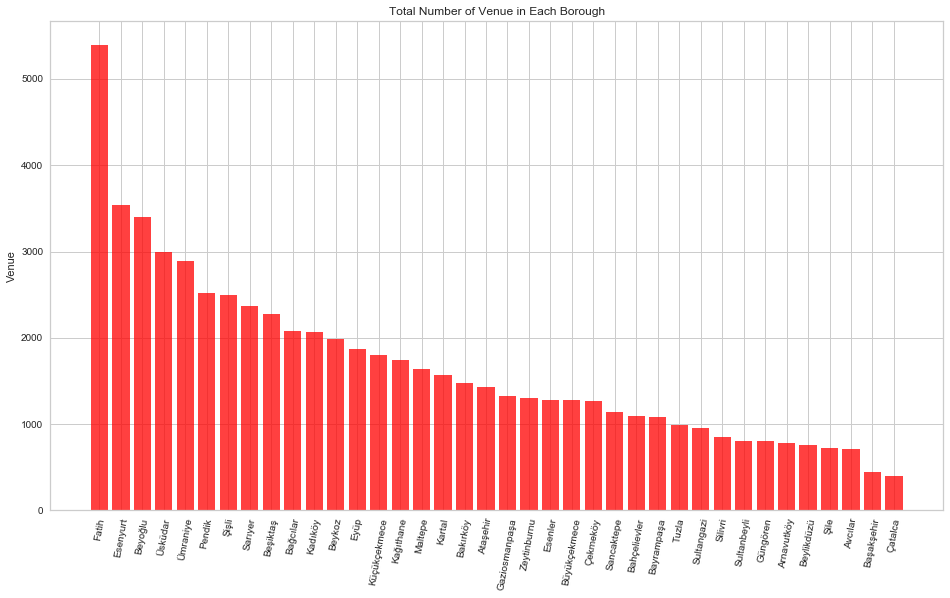

In [33]:
x_ax = np.arange(count_for_bor.shape[0])
y_ax = count_for_bor.Venue

plt.figure(figsize=(16,9))
plt.bar(x_ax, y_ax, align='center', color='red', alpha=0.75)
plt.xticks(x_ax, count_for_bor.Boroughs)

plt.ylabel('Venue')
plt.title('Total Number of Venue in Each Borough')
plt.xticks(rotation=80)

plt.show()

According to figure above; we can say that Fatih, Esenyurt, Beyoğlu, Üsküdar, Ümraniye, Pendik, Şişli, Sarıyer, Beşiktaş, Bağcılar and Kadıköy boroughs are above 2000 venues. On the other hand; Tuzla, Sultangazi, Silivri, Sultanbeyli, Güngören, Arnavutköy, Beylikdüzü, Şile, Avcılar, Başakşehir and Çatalca boroughs are below 1000 venues in our given coordinates with Latitude and Longitude. Now, let's create figures for boroughs and their population, density.  

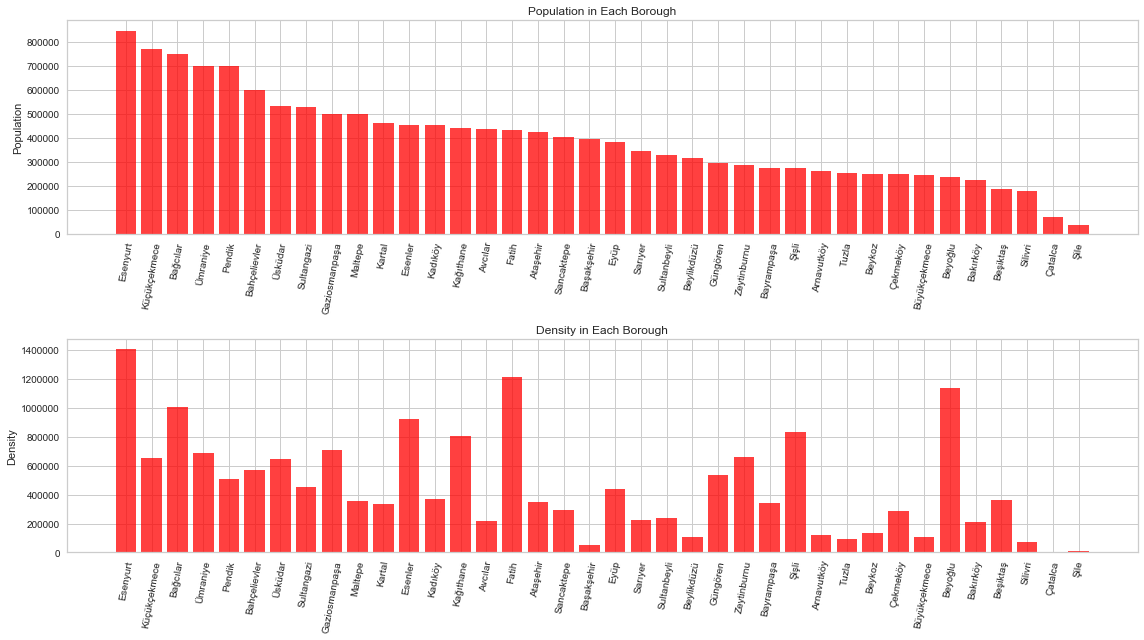

In [34]:
compared_df = istanbul_boroughs.sort_values('Population', ascending = False)

x_ax1 = np.arange(compared_df.shape[0])
y_ax1 = compared_df.Population

plt.figure(figsize=(16,9))

plt.subplot(2, 1, 1)
plt.bar(x_ax1, y_ax1, align='center', color='red', alpha=0.75)
plt.xticks(x_ax1, compared_df.Boroughs)

plt.ylabel('Population')
plt.title('Population in Each Borough')
plt.xticks(rotation=80)

# For dense graph
x_ax2 = np.arange(compared_df.shape[0])
y_ax2 = compared_df.Density


plt.subplot(2, 1, 2)
plt.bar(x_ax2, y_ax2, align='center', color='red', alpha=0.75)
plt.xticks(x_ax1, compared_df.Boroughs)

plt.ylabel('Density')
plt.title('Density in Each Borough')
plt.xticks(rotation=80)

plt.tight_layout()
plt.show()

Based on these figures, we can say that there are many venues in Fatih, Esenyurt, Bağcılar, Beyoğlu, Şişli and Ümraniye but these boroughs are also very crowded. Conversely; Sarıyer, Kadıköy and Beşiktaş boroughs are above 2000 venues and not very populated. On the other hand; population density is also low in boroughs such as Başakşehir, Çatalca and Şile. Now, let's create figures for neighborhoods of Fatih, Sarıyer and Başakşehir.

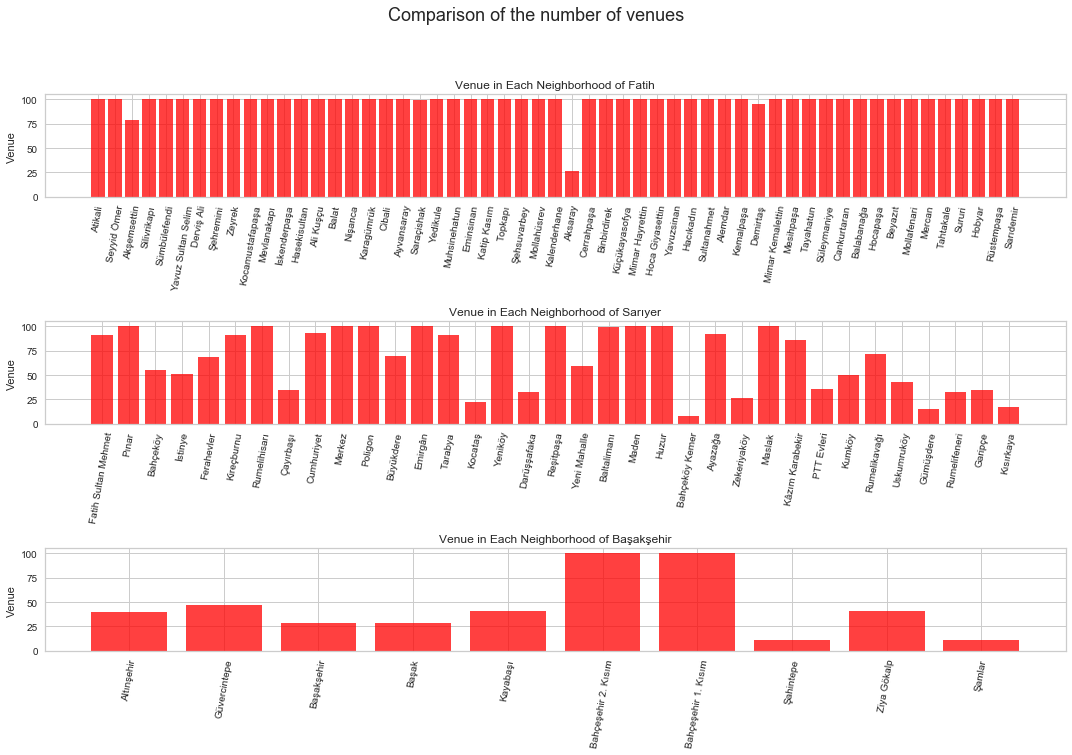

In [35]:
df_fatih = pd.DataFrame(df_istanbul[df_istanbul['Boroughs']=='Fatih'].merge(count_for_nei, on='Neighborhood'))
df_sariyer = pd.DataFrame(df_istanbul[df_istanbul['Boroughs']=='Sarıyer'].merge(count_for_nei, on='Neighborhood'))
df_basaksehir = pd.DataFrame(df_istanbul[df_istanbul['Boroughs']=='Başakşehir'].merge(count_for_nei, on='Neighborhood'))

# For Fatih
neihgborhood_fatih = []
for i in range(len(df_fatih)):
    neihgborhood_fatih.append(df_fatih.Neighborhood.str.split(',')[i][0])
    

x_ax3 = np.arange(df_fatih.shape[0])
y_ax3 = df_fatih.Venue

plt.figure(figsize=(15,11))
plt.suptitle('Comparison of the number of venues', fontsize = 18)

plt.subplot(3, 1, 1)
plt.bar(x_ax3, y_ax3, align='center', color='red', alpha=0.75)
plt.xticks(x_ax3, neihgborhood_fatih)

plt.ylabel('Venue')
plt.title('Venue in Each Neighborhood of Fatih')
plt.xticks(rotation=80)

# For Sarıyer
neighborhood_sariyer = []
for i in range(len(df_sariyer)):
    neighborhood_sariyer.append(df_sariyer.Neighborhood.str.split(',')[i][0])

x_ax4 = np.arange(df_sariyer.shape[0])
y_ax4 = df_sariyer.Venue


plt.subplot(3, 1, 2)
plt.bar(x_ax4, y_ax4, align='center', color='red', alpha=0.75)
plt.xticks(x_ax4, neighborhood_sariyer)

plt.ylabel('Venue')
plt.title('Venue in Each Neighborhood of Sarıyer')
plt.xticks(rotation=80)

# For Başakşehir
neighborhood_basaksehir = []
for i in range(len(df_basaksehir)):
    neighborhood_basaksehir.append(df_basaksehir.Neighborhood.str.split(',')[i][0])

x_ax5 = np.arange(df_basaksehir.shape[0])
y_ax5 = df_basaksehir.Venue


plt.subplot(3, 1, 3)
plt.bar(x_ax5, y_ax5, align='center', color='red', alpha=0.75)
plt.xticks(x_ax5, neighborhood_basaksehir)

plt.ylabel('Venue')
plt.title('Venue in Each Neighborhood of Başakşehir')
plt.xticks(rotation=80)

plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

Almost all neighborhoods of Fatih have reached the limit of 100. Most of Sarıyer's neighborhoods are above 50, but Başakşehir's neighborhoods are generally even below 50. Now, let's compare the densities of these neighborhoods.

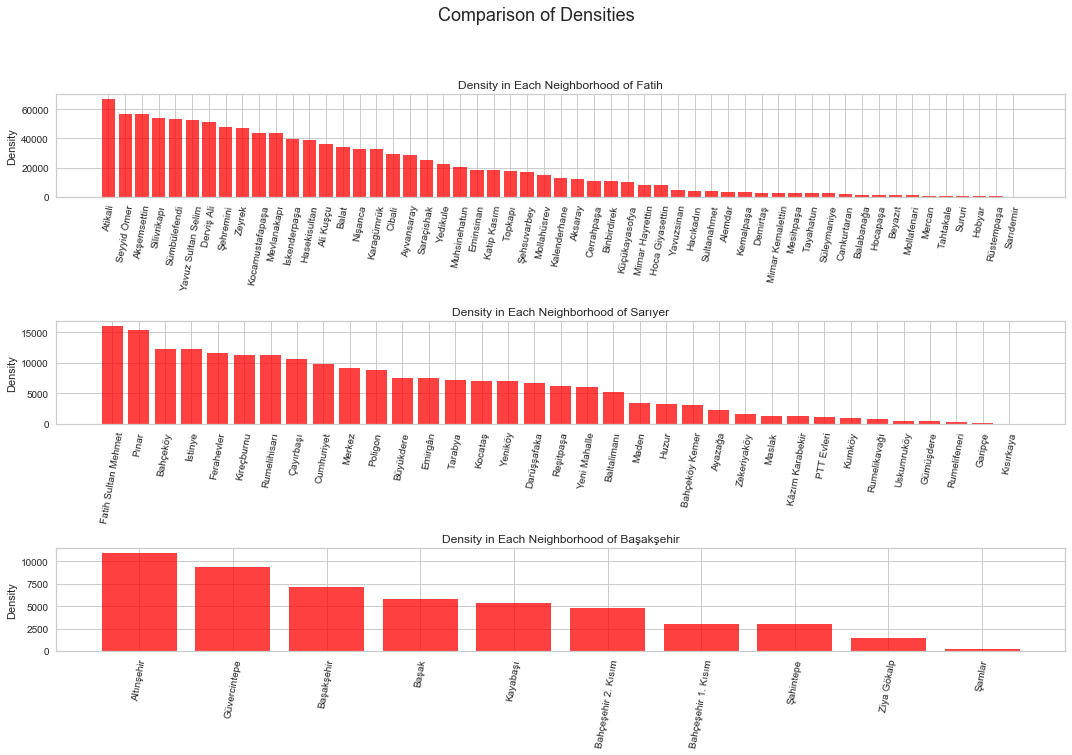

In [36]:
x_ax6 = np.arange(df_fatih.shape[0])
y_ax6 = df_fatih.Density

plt.figure(figsize=(15,11))
plt.suptitle('Comparison of Densities', fontsize = 18)

plt.subplot(3, 1, 1)
plt.bar(x_ax6, y_ax6, align='center', color='red', alpha=0.75)
plt.xticks(x_ax6, neihgborhood_fatih)

plt.ylabel('Density')
plt.title('Density in Each Neighborhood of Fatih')
plt.xticks(rotation=80)

# For Sarıyer

x_ax7 = np.arange(df_sariyer.shape[0])
y_ax7 = df_sariyer.Density


plt.subplot(3, 1, 2)
plt.bar(x_ax7, y_ax7, align='center', color='red', alpha=0.75)
plt.xticks(x_ax7, neighborhood_sariyer)

plt.ylabel('Density')
plt.title('Density in Each Neighborhood of Sarıyer')
plt.xticks(rotation=80)

# For Başakşehir

x_ax8 = np.arange(df_basaksehir.shape[0])
y_ax8 = df_basaksehir.Density


plt.subplot(3, 1, 3)
plt.bar(x_ax8, y_ax8, align='center', color='red', alpha=0.75)
plt.xticks(x_ax8, neighborhood_basaksehir)

plt.ylabel('Density')
plt.title('Density in Each Neighborhood of Başakşehir')
plt.xticks(rotation=80)

plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

Although the number of neighborhoods is small in Başakşehir; density is below 10000. Conversely, most of Fatih's neighborhoods are above 20000 and density in the neighborhoods of Sarıyer is squeezed between 5000 and 15000.

### 2.4 Cluster neighborhoods with *K-means*

*K-means* algorithm is one of the most popular unsupervised learning techniques used for clustering problems. We will also use this algorithm in this project. Firstly, we need to normalize columns(*Population, Area, Density*) with continuous values. We use **StandardScaler()** to normalize them. 

In [38]:
# Firstly, add these columns into istanbul_grouped
istanbul_main = istanbul_grouped.merge(df_istanbul[['Neighborhood','Population','Area','Density','Latitude',
                                                   'Longitude']], on='Neighborhood')

X = istanbul_main[['Population','Area','Density']]
normalized = StandardScaler().fit_transform(X)
df_normalized = pd.DataFrame(normalized)
df_normalized.head()

0         1         2
0 -0.484376  0.189949 -0.866433
1  0.914649 -0.384436  0.225312
2 -0.285661 -0.464109  0.406806
3  3.625787 -0.402965  2.302100
4  1.060772 -0.414082  0.758416

Add these columns to our main dataframe.

In [39]:
istanbul_main['Population'] = df_normalized[0]
istanbul_main['Area'] = df_normalized[1]
istanbul_main['Density'] = df_normalized[2]
istanbul_main.head()

Neighborhood  ATM  Accessories Store  Adult Boutique  \
0  19 Mayıs, Büyükçekmece  0.0                0.0             0.0   
1       19 Mayıs, Kadıköy  0.0                0.0             0.0   
2         19 Mayıs, Şişli  0.0                0.0             0.0   
3     50. Yıl, Sultangazi  0.0                0.0             0.0   
4     75. Yıl, Sultangazi  0.0                0.0             0.0   

   Adult Education Center  Advertising Agency  Afghan Restaurant  \
0                     0.0                 0.0                0.0   
1                     0.0                 0.0                0.0   
2                     0.0                 0.0                0.0   
3                     0.0                 0.0                0.0   
4                     0.0                 0.0                0.0   

   African Restaurant  Airport  Airport Gate  ...  Yemeni Restaurant  \
0                 0.0      0.0           0.0  ...                0.0   
1                 0.0      0.0           0.0  ...                0.0   
2                 0.0      0.0           0.0  ...                0.0   
3                 0.0      0.0           0.0  ...                0.0   
4                 0.0      0.0           0.0  ...                0.0   

   Yoga Studio  Zoo  Zoo Exhibit  Çöp Şiş Place  Population      Area  \
0          0.0  0.0          0.0            0.0   -0.484376  0.189949   
1          0.0  0.0          0.0            0.0    0.914649 -0.384436   
2          0.0  0.0          0.0            0.0   -0.285661 -0.464109   
3          0.0  0.0          0.0            0.0    3.625787 -0.402965   
4          0.0  0.0          0.0            0.0    1.060772 -0.414082   

    Density   Latitude  Longitude  
0 -0.866433  41.052765  28.424218  
1  0.225312  40.977661  29.092549  
2  0.406806  41.064506  28.992770  
3  2.302100  41.087810  28.866929  
4  0.758416  41.095557  28.902118  

[5 rows x 547 columns]

In [95]:
# Drop neigborhood column as it should not be considered in the clustering
istanbul_clustered = istanbul_main.drop(['Neighborhood'], axis=1)
istanbul_clustered.head()

ATM  Accessories Store  Adult Boutique  Adult Education Center  \
0  0.0                0.0             0.0                     0.0   
1  0.0                0.0             0.0                     0.0   
2  0.0                0.0             0.0                     0.0   
3  0.0                0.0             0.0                     0.0   
4  0.0                0.0             0.0                     0.0   

   Advertising Agency  Afghan Restaurant  African Restaurant  Airport  \
0                 0.0                0.0                 0.0      0.0   
1                 0.0                0.0                 0.0      0.0   
2                 0.0                0.0                 0.0      0.0   
3                 0.0                0.0                 0.0      0.0   
4                 0.0                0.0                 0.0      0.0   

   Airport Gate  Airport Lounge  ...  Yemeni Restaurant  Yoga Studio  Zoo  \
0           0.0             0.0  ...                0.0          0.0  0.0   
1           0.0             0.0  ...                0.0          0.0  0.0   
2           0.0             0.0  ...                0.0          0.0  0.0   
3           0.0             0.0  ...                0.0          0.0  0.0   
4           0.0             0.0  ...                0.0          0.0  0.0   

   Zoo Exhibit  Çöp Şiş Place  Population      Area   Density   Latitude  \
0          0.0            0.0   -0.484376  0.189949 -0.866433  41.052765   
1          0.0            0.0    0.914649 -0.384436  0.225312  40.977661   
2          0.0            0.0   -0.285661 -0.464109  0.406806  41.064506   
3          0.0            0.0    3.625787 -0.402965  2.302100  41.087810   
4          0.0            0.0    1.060772 -0.414082  0.758416  41.095557   

   Longitude  
0  28.424218  
1  29.092549  
2  28.992770  
3  28.866929  
4  28.902118  

[5 rows x 546 columns]

According to elbow method, 6 is the optimum value for *k*. So, Run *k*-means to cluster the neighborhood into 6 clusters.

In [110]:
# Set number of clusters
kclusters = 6

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(istanbul_clustered)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 0, 3, 3, 4, 4, 3, 3, 0])

In [111]:
neighborhoods_venues_sorted.drop(['Cluster_Labels'], axis=1, inplace=True)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [112]:
# Add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

istanbul_merged = df_istanbul

# Merge istanbul_grouped with manhattan_data to add latitude/longitude for each neighborhood
istanbul_merged = istanbul_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

istanbul_merged.head() # check the last columns!

Neighborhood     Boroughs  Density  Population  Area  \
0    Yeşiltepe, Zeytinburnu  Zeytinburnu  96576.0     21679.0  0.22   
1            Fatih, Esenler      Esenler  89562.0     45797.0  0.51   
3        Nenehatun, Esenler      Esenler  86504.0     43328.0  0.50   
4         Yenigün, Bağcılar     Bağcılar  84843.0     23112.0  0.27   
5  Kâzım Karabekir, Esenler      Esenler  84393.0     35790.0  0.42   

    Latitude  Longitude  Cluster_Labels 1st Most Common Venue  \
0  40.992219  28.900607             4.0    Turkish Restaurant   
1  41.041988  28.865682             4.0                  Café   
3  41.035747  28.878859             4.0                  Café   
4  41.022218  28.859602             4.0    Turkish Restaurant   
5  41.045372  28.873215             4.0                  Café   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                  Café            Restaurant  Gym / Fitness Center   
1                   Gym                Bakery    Turkish Restaurant   
3                   Gym  Gym / Fitness Center    Turkish Restaurant   
4                  Café        Breakfast Spot           Coffee Shop   
5  Gym / Fitness Center        Clothing Store                   Gym   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0        Ice Cream Shop   Arts & Crafts Store          Dessert Shop   
1                  Park        Breakfast Spot                 Plaza   
3        Clothing Store           Snack Place            Restaurant   
4            Steakhouse                   Gym     Electronics Store   
5     Electronics Store    Turkish Restaurant           Pizza Place   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0           Coffee Shop      Doner Restaurant       Department Store  
1            Hookah Bar  Gym / Fitness Center           Dessert Shop  
3          Burger Joint            Steakhouse         Ice Cream Shop  
4        Cosmetics Shop  Gym / Fitness Center     Seafood Restaurant  
5           Snack Place                Arcade             Steakhouse

In [113]:
istanbul_merged[istanbul_merged['Cluster_Labels'].isnull()]

Neighborhood  Boroughs  Density  Population   Area   Latitude  \
47   Merkez, Güngören  Güngören  60285.0     47371.0   0.79  39.078617   
951    Avcıkoru, Şile      Şile      6.5       130.0  20.10  41.133333   

     Longitude  Cluster_Labels 1st Most Common Venue 2nd Most Common Venue  \
47   40.292355             NaN                   NaN                   NaN   
951  29.400000             NaN                   NaN                   NaN   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
47                    NaN                   NaN                   NaN   
951                   NaN                   NaN                   NaN   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
47                    NaN                   NaN                   NaN   
951                   NaN                   NaN                   NaN   

    9th Most Common Venue 10th Most Common Venue  
47                    NaN                    NaN  
951                   NaN                    NaN

For Merkez, Güngören and Avcıkoru, Şile there is no venue information. So, we will drop them.

In [114]:
istanbul_merged = istanbul_merged[istanbul_merged['Cluster_Labels'].notna()]
istanbul_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 910 entries, 0 to 953
Data columns (total 18 columns):
Neighborhood              910 non-null object
Boroughs                  910 non-null object
Density                   910 non-null float64
Population                910 non-null float64
Area                      910 non-null float64
Latitude                  910 non-null float64
Longitude                 910 non-null float64
Cluster_Labels            910 non-null float64
1st Most Common Venue     910 non-null object
2nd Most Common Venue     910 non-null object
3rd Most Common Venue     910 non-null object
4th Most Common Venue     910 non-null object
5th Most Common Venue     910 non-null object
6th Most Common Venue     910 non-null object
7th Most Common Venue     910 non-null object
8th Most Common Venue     910 non-null object
9th Most Common Venue     910 non-null object
10th Most Common Venue    910 non-null object
dtypes: float64(6), object(12)
memory usage: 135.1+ KB


We should convert the *floats* to *integer* for **Cluster_Labels** column.

In [115]:
istanbul_merged.Cluster_Labels = istanbul_merged.Cluster_Labels.astype(int)
istanbul_merged.head()

Neighborhood     Boroughs  Density  Population  Area  \
0    Yeşiltepe, Zeytinburnu  Zeytinburnu  96576.0     21679.0  0.22   
1            Fatih, Esenler      Esenler  89562.0     45797.0  0.51   
3        Nenehatun, Esenler      Esenler  86504.0     43328.0  0.50   
4         Yenigün, Bağcılar     Bağcılar  84843.0     23112.0  0.27   
5  Kâzım Karabekir, Esenler      Esenler  84393.0     35790.0  0.42   

    Latitude  Longitude  Cluster_Labels 1st Most Common Venue  \
0  40.992219  28.900607               4    Turkish Restaurant   
1  41.041988  28.865682               4                  Café   
3  41.035747  28.878859               4                  Café   
4  41.022218  28.859602               4    Turkish Restaurant   
5  41.045372  28.873215               4                  Café   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                  Café            Restaurant  Gym / Fitness Center   
1                   Gym                Bakery    Turkish Restaurant   
3                   Gym  Gym / Fitness Center    Turkish Restaurant   
4                  Café        Breakfast Spot           Coffee Shop   
5  Gym / Fitness Center        Clothing Store                   Gym   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0        Ice Cream Shop   Arts & Crafts Store          Dessert Shop   
1                  Park        Breakfast Spot                 Plaza   
3        Clothing Store           Snack Place            Restaurant   
4            Steakhouse                   Gym     Electronics Store   
5     Electronics Store    Turkish Restaurant           Pizza Place   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0           Coffee Shop      Doner Restaurant       Department Store  
1            Hookah Bar  Gym / Fitness Center           Dessert Shop  
3          Burger Joint            Steakhouse         Ice Cream Shop  
4        Cosmetics Shop  Gym / Fitness Center     Seafood Restaurant  
5           Snack Place                Arcade             Steakhouse

Finally, let's visualize the resulting clusters.

In [117]:
# Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(istanbul_merged['Latitude'], istanbul_merged['Longitude'], istanbul_merged['Neighborhood'], istanbul_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 2.5 Examine clusters

Now, we will examine each cluster and determine the discriminating venue categories that distinguish each cluster.

In [116]:
istanbul_merged['Cluster_Labels'].value_counts()

0    495
4    157
3    144
2    107
5      6
1      1
Name: Cluster_Labels, dtype: int64

In [137]:
# Collect each cluster in dataframes.
cluster0 = istanbul_merged[istanbul_merged['Cluster_Labels']==0]
cluster1 = istanbul_merged[istanbul_merged['Cluster_Labels']==1]
cluster2 = istanbul_merged[istanbul_merged['Cluster_Labels']==2]
cluster3 = istanbul_merged[istanbul_merged['Cluster_Labels']==3]
cluster4 = istanbul_merged[istanbul_merged['Cluster_Labels']==4]
cluster5 = istanbul_merged[istanbul_merged['Cluster_Labels']==5]
cluster4.head()

Neighborhood     Boroughs  Density  Population  Area  \
0    Yeşiltepe, Zeytinburnu  Zeytinburnu  96576.0     21679.0  0.22   
1            Fatih, Esenler      Esenler  89562.0     45797.0  0.51   
3        Nenehatun, Esenler      Esenler  86504.0     43328.0  0.50   
4         Yenigün, Bağcılar     Bağcılar  84843.0     23112.0  0.27   
5  Kâzım Karabekir, Esenler      Esenler  84393.0     35790.0  0.42   

    Latitude  Longitude  Cluster_Labels 1st Most Common Venue  \
0  40.992219  28.900607               4    Turkish Restaurant   
1  41.041988  28.865682               4                  Café   
3  41.035747  28.878859               4                  Café   
4  41.022218  28.859602               4    Turkish Restaurant   
5  41.045372  28.873215               4                  Café   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                  Café            Restaurant  Gym / Fitness Center   
1                   Gym                Bakery    Turkish Restaurant   
3                   Gym  Gym / Fitness Center    Turkish Restaurant   
4                  Café        Breakfast Spot           Coffee Shop   
5  Gym / Fitness Center        Clothing Store                   Gym   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0        Ice Cream Shop   Arts & Crafts Store          Dessert Shop   
1                  Park        Breakfast Spot                 Plaza   
3        Clothing Store           Snack Place            Restaurant   
4            Steakhouse                   Gym     Electronics Store   
5     Electronics Store    Turkish Restaurant           Pizza Place   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0           Coffee Shop      Doner Restaurant       Department Store  
1            Hookah Bar  Gym / Fitness Center           Dessert Shop  
3          Burger Joint            Steakhouse         Ice Cream Shop  
4        Cosmetics Shop  Gym / Fitness Center     Seafood Restaurant  
5           Snack Place                Arcade             Steakhouse

Let's create a map of each clusters.

In [138]:
map_cluster0 = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(cluster0['Latitude'], cluster0['Longitude'], cluster0['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cluster0)  
    
map_cluster0

In [140]:
map_cluster2 = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(cluster2['Latitude'], cluster2['Longitude'], cluster2['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cluster2)  
    
map_cluster2

In [141]:
map_cluster3 = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(cluster3['Latitude'], cluster3['Longitude'], cluster3['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cluster3)  
    
map_cluster3

In [142]:
map_cluster4 = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(cluster4['Latitude'], cluster4['Longitude'], cluster4['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cluster4)  
    
map_cluster4

Let's calculate average of population for all clusters.

In [135]:
for i in range(6):
    print("Average population for Cluster {}: {}".format(i,istanbul_merged[istanbul_merged['Cluster_Labels']==i]['Population'].mean()))

Average population for Cluster 0: 9491.357575757576
Average population for Cluster 1: 219.0
Average population for Cluster 2: 2565.1869158878503
Average population for Cluster 3: 41345.8125
Average population for Cluster 4: 22017.95541401274
Average population for Cluster 5: 21005.5


In [136]:
for i in range(6):
    print("Average density for Cluster {}: {}".format(i,istanbul_merged[istanbul_merged['Cluster_Labels']==i]['Density'].mean()))

Average density for Cluster 0: 9353.638585858582
Average density for Cluster 1: 11.2
Average density for Cluster 2: 102.89532710280368
Average density for Cluster 3: 25748.5
Average density for Cluster 4: 51750.70700636943
Average density for Cluster 5: 20705.0


Cluster 4 and Cluster 3 are more populated. Now, we will find **1st Most Common Venue** for each cluster.

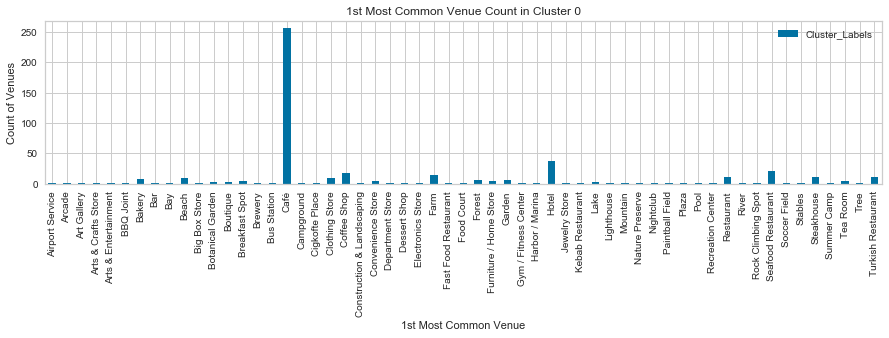

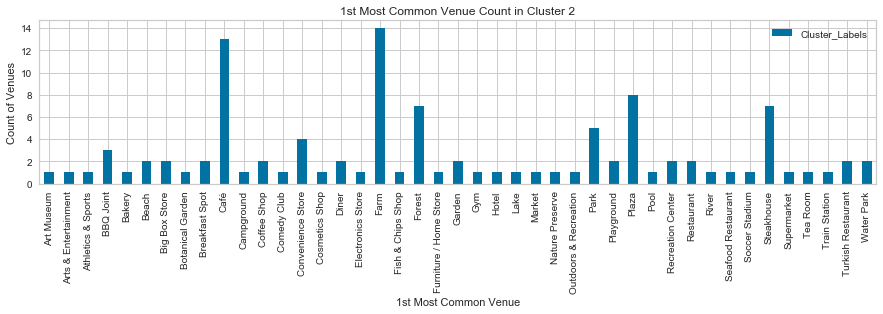

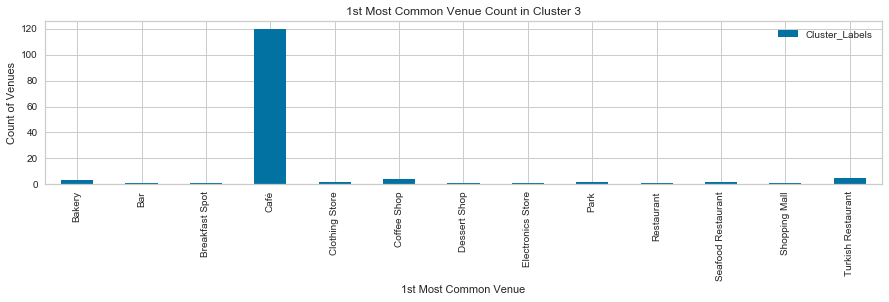

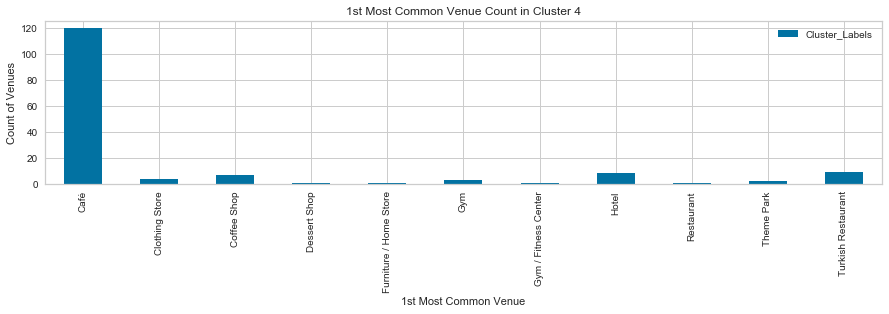

In [144]:
# 1st Common Venue Cluster 0
ax0 = cluster0.groupby(['1st Most Common Venue'], as_index=False).count().plot(kind='bar', 
                                                                         x='1st Most Common Venue', y='Cluster_Labels',
                                                                         figsize = (15,3));
ax0.set_title('1st Most Common Venue Count in Cluster 0');
ax0.set_xlabel('1st Most Common Venue');
ax0.set_ylabel('Count of Venues');


# 1st Common Venue Cluster 1
ax2 = cluster2.groupby(['1st Most Common Venue'], as_index=False).count().plot(kind='bar', 
                                                                         x='1st Most Common Venue', y='Cluster_Labels',
                                                                         figsize = (15,3));
ax2.set_title('1st Most Common Venue Count in Cluster 2');
ax2.set_xlabel('1st Most Common Venue');
ax2.set_ylabel('Count of Venues');

# 1st Common Venue Cluster 3
ax3 = cluster3.groupby(['1st Most Common Venue'], as_index=False).count().plot(kind='bar', 
                                                                         x='1st Most Common Venue', y='Cluster_Labels',
                                                                         figsize = (15,3));
ax3.set_title('1st Most Common Venue Count in Cluster 3');
ax3.set_xlabel('1st Most Common Venue');
ax3.set_ylabel('Count of Venues');

# 1st Common Venue Cluster 4
ax4 = cluster4.groupby(['1st Most Common Venue'], as_index=False).count().plot(kind='bar', 
                                                                         x='1st Most Common Venue', y='Cluster_Labels',
                                                                         figsize = (15,3));
ax4.set_title('1st Most Common Venue Count in Cluster 4');
ax4.set_xlabel('1st Most Common Venue');
ax4.set_ylabel('Count of Venues');

## 3. Conclusion

Based on these figures; we can say that Cluster 2 is a little further away from the city center. Because the number of farms, parks and forests are pointing it. There are so many different categories in Cluster 0, and this indicates that there is a lot of human traffic in this area and Cluster 0 is also less populated it indicates that this cluster attracts more tourists.  Additionally, the numbers of cafes in Cluster 3 and Cluster 4 indicate that these are settlements. They are also very populated.